In [81]:
from skimage import io
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.decomposition import PCA
from skimage.transform import SimilarityTransform
from skimage.transform import warp
import os
import pathlib
import random 

# Exercise 1

In [82]:
def read_landmark_file(file_name):
    f = open(file_name, 'r')
    lm_s = f.readline().strip().split(' ')
    n_lms = int(lm_s[0])
    if n_lms < 3:
        print(f"Not enough landmarks found")
        return None

    new_lms = 3
    # 3 landmarks each with (x,y)
    lm = np.zeros((new_lms, 2))
    for i in range(new_lms):
        lm[i, 0] = lm_s[1 + i * 2]
        lm[i, 1] = lm_s[2 + i * 2]
    return lm

def align_and_crop_one_cat_to_destination_cat(img_src, lm_src, img_dst, lm_dst):
    """
    Landmark based alignment of one cat image to a destination
    :param img_src: Image of source cat
    :param lm_src: Landmarks for source cat
    :param lm_dst: Landmarks for destination cat
    :return: Warped and cropped source image. None if something did not work
    """
    tform = SimilarityTransform()
    tform.estimate(lm_src, lm_dst)
    warped = warp(img_src, tform.inverse, output_shape=img_dst.shape)

    # Center of crop region
    cy = 185
    cx = 210
    # half the size of the crop box
    sz = 180
    warp_crop = warped[cy - sz:cy + sz, cx - sz:cx + sz]
    shape = warp_crop.shape
    if shape[0] == sz * 2 and shape[1] == sz * 2:
        return img_as_ubyte(warp_crop)
    else:
        print(f"Could not crop image. It has shape {shape}. Probably to close to border of image")
        return None
    

def preprocess_all_cats(in_dir, out_dir):
    """
    Create aligned and cropped version of image
    :param in_dir: Where are the original photos and landmark files
    :param out_dir: Where should the preprocessed files be placed
    """
    dst = "data/ModelCat"
    dst_lm = read_landmark_file(f"{dst}.jpg.cat")
    dst_img = io.imread(f"{dst}.jpg")

    print(f"Found {len(glob.glob(in_dir + '*.jpg'))} images")

    all_images = glob.glob(in_dir + "*.jpg")
    for img_idx in all_images:
        name_no_ext = os.path.splitext(img_idx)[0]
        base_name = os.path.basename(name_no_ext)
        out_name = f"{out_dir}/{base_name}_preprocessed.jpg"

        src_lm = read_landmark_file(f"{name_no_ext}.jpg.cat")
        src_img = io.imread(f"{name_no_ext}.jpg")

        proc_img = align_and_crop_one_cat_to_destination_cat(src_img, src_lm, dst_img, dst_lm)
        if proc_img is not None:
            io.imsave(out_name, proc_img)

def preprocess_one_cat():
    src = "data/MissingCat"
    dst = "data/ModelCat"
    out = "data/MissingCatProcessed.jpg"

    src_lm = read_landmark_file(f"{src}.jpg.cat")
    dst_lm = read_landmark_file(f"{dst}.jpg.cat")

    src_img = io.imread(f"{src}.jpg")
    dst_img = io.imread(f"{dst}.jpg")

    src_proc = align_and_crop_one_cat_to_destination_cat(src_img, src_lm, dst_img, dst_lm)
    if src_proc is None:
        return

    io.imsave(out, src_proc)

    fig, ax = plt.subplots(ncols=3, figsize=(16, 6))
    ax[0].imshow(src_img)
    ax[0].plot(src_lm[:, 0], src_lm[:, 1], '.r', markersize=12)
    ax[1].imshow(dst_img)
    ax[1].plot(dst_lm[:, 0], dst_lm[:, 1], '.r', markersize=12)
    ax[2].imshow(src_proc)
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()

def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out

In [83]:
in_dir = "/home/aw/Dropbox/education/uni/7_semester/imageAnal/DTUImageAnalysis/exercises/ex8-CatsCatsCats/data/training_data/"
out_dir = "/home/aw/Dropbox/education/uni/7_semester/imageAnal/DTUImageAnalysis/exercises/ex8-CatsCatsCats/data/preprocessed/"

preprocess_all_cats(in_dir, out_dir)

Found 1706 images


/tmp/ipykernel_1175374/788472997.py:66: UserWarning: /home/aw/Dropbox/education/uni/7_semester/imageAnal/DTUImageAnalysis/exercises/ex8-CatsCatsCats/data/preprocessed//00000059_002_preprocessed.jpg is a low contrast image
  io.imsave(out_name, proc_img)


# Exercise 2

In [84]:
all_images = glob.glob(out_dir + '*.jpg')
n_samples = len(all_images)
print(f"Found {n_samples} images")

Found 1706 images


In [85]:
first_photo = glob.glob(out_dir + '*.jpg')[0]
img = io.imread(first_photo)
print("Image dimensions:", img.shape)  

n_features = img.shape[0] * img.shape[1] * img.shape[2]
print("Number of features:", n_features)

Image dimensions: (360, 360, 3)
Number of features: 388800


In [86]:
data_matrix = np.zeros((n_samples, n_features))

for idx, image in enumerate(all_images):
    data_matrix[idx, :] = io.imread(image).flatten()

# Exercise 3

In [87]:
data_matrix[:,0]

array([ 74.,   0.,  55., ...,  53., 184., 248.])

In [88]:
average_cat = np.mean(data_matrix, axis=0)
average_cat

array([ 97.67467761,  91.35228605,  80.97362251, ..., 102.64361079,
        94.29425557,  83.27491208])

# Exercise 4

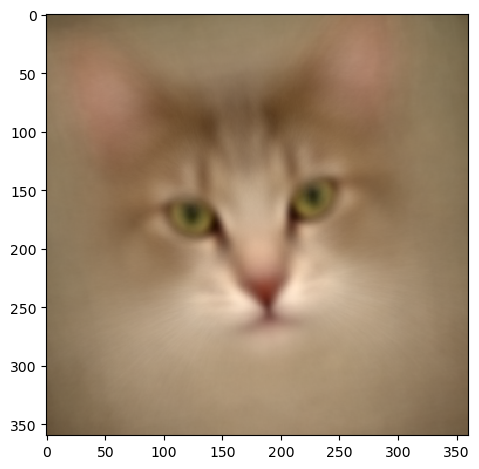

In [89]:
average_cat_img = create_u_byte_image_from_vector(average_cat, 360,360,3)
io.imshow(average_cat_img)

# Exercise 5

# Exercise 6

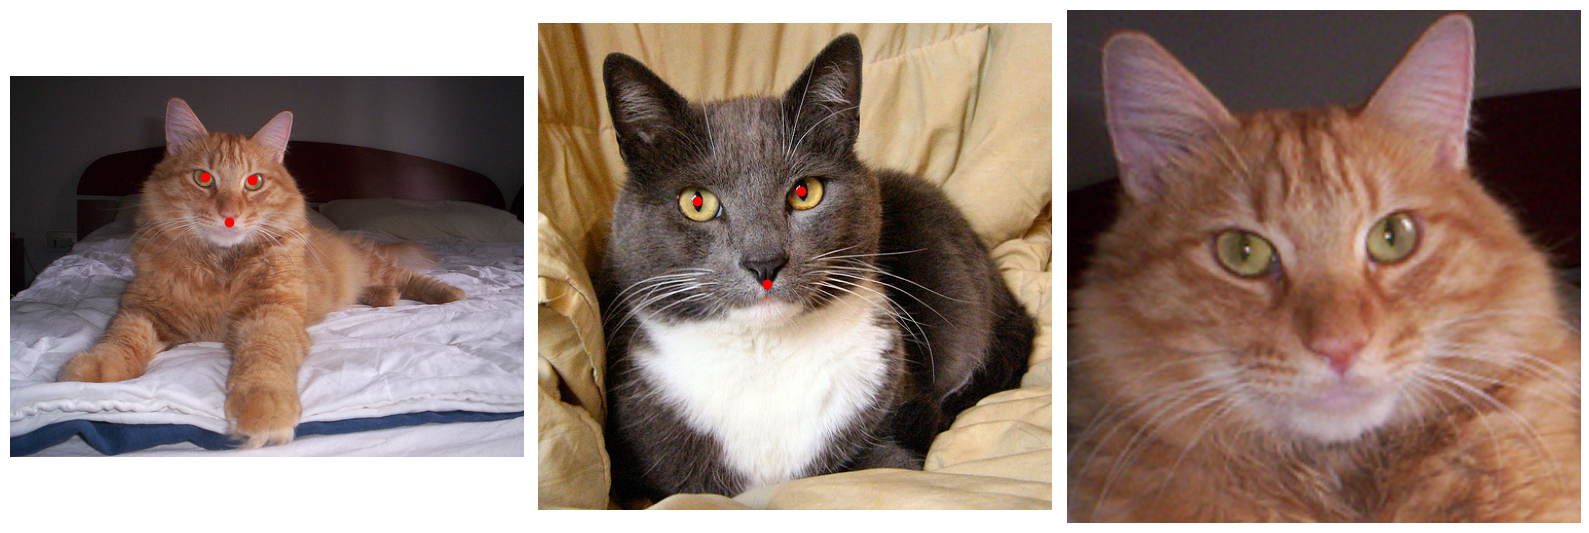

In [90]:
preprocess_one_cat()

# Exercise 7

In [91]:
img_miss_flat = io.imread("data/MissingCatProcessed.jpg").flatten()

# Exercise 8

In [92]:
sub_data = data_matrix - img_miss_flat
sub_distances = np.linalg.norm(sub_data, axis=1)

# Exercise 9

In [93]:
replacement_cat_idx = np.argmin(sub_distances)
replacement_cat_idx

961

# Exercise 10
The neighbor won't notice

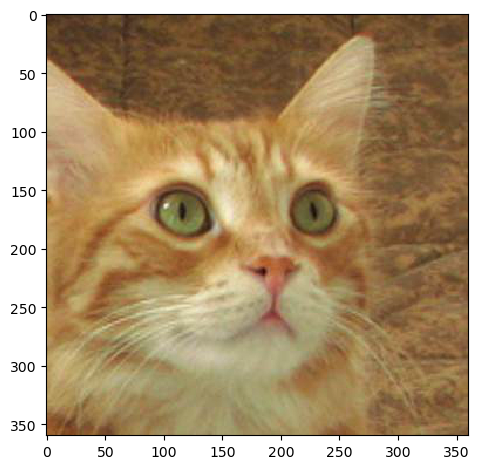

In [94]:
replacement_cat = create_u_byte_image_from_vector(data_matrix[replacement_cat_idx,:],360,360,3)
io.imshow(replacement_cat)

# Exercise 11

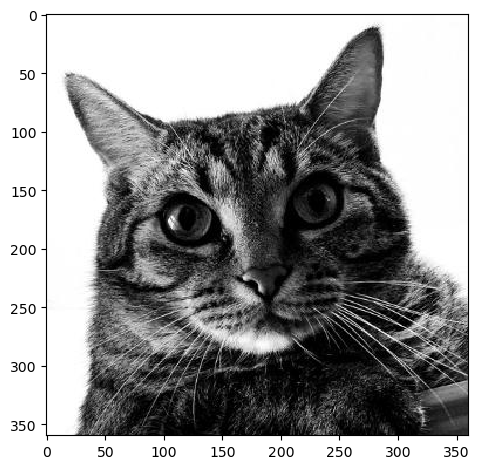

In [95]:
max_cat_idx = np.argmax(sub_distances)
max_cat = create_u_byte_image_from_vector(data_matrix[max_cat_idx,:],360,360,3)
io.imshow(max_cat)


# Exercise 12

In [96]:
print("Computing PCA")
cats_pca = PCA(n_components=50)
cats_pca.fit(data_matrix)

Computing PCA


PCA(n_components=50)

# Exercise 13

In [97]:
# Calculate cumulative sum
cum_vr = np.cumsum(cats_pca.explained_variance_ratio_)
cum_vr

array([0.18712523, 0.30846212, 0.39855012, 0.46777418, 0.500636  ,
       0.53001042, 0.55510624, 0.57723649, 0.59741144, 0.61696383,
       0.63381975, 0.64707174, 0.65857001, 0.66813413, 0.67732063,
       0.68556072, 0.69357403, 0.70110552, 0.70732366, 0.71315499,
       0.71878844, 0.72400578, 0.72886676, 0.73341264, 0.737801  ,
       0.74207672, 0.74623154, 0.7499078 , 0.75352174, 0.75697906,
       0.76035054, 0.76356415, 0.76673614, 0.76976277, 0.77263518,
       0.77544101, 0.7781691 , 0.78078368, 0.78328004, 0.78568676,
       0.78805659, 0.79035406, 0.79264056, 0.79482893, 0.79695531,
       0.79905883, 0.80113278, 0.80309045, 0.80500162, 0.80680163])

<function matplotlib.pyplot.show(close=None, block=None)>

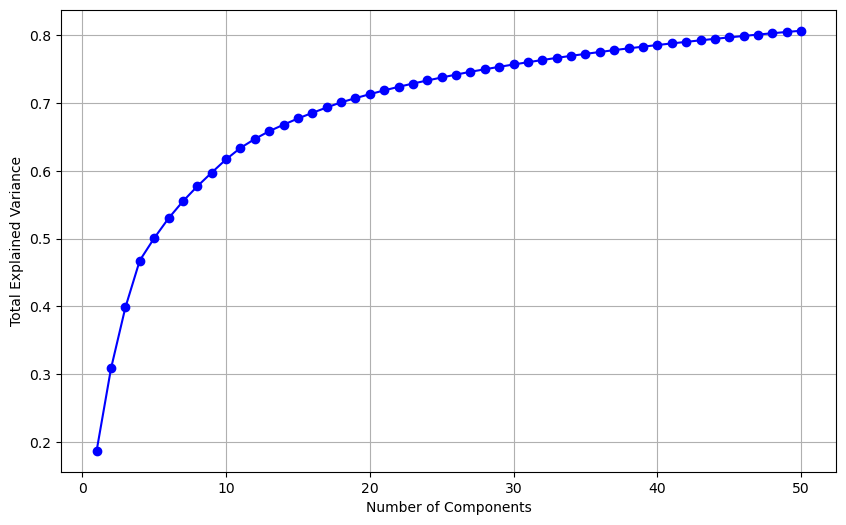

In [98]:
plt.figure(figsize=(10,6))
plt.plot(range(1,len(cum_vr)+1),cum_vr, 'bo-')
plt.xlabel("Number of Components")
plt.ylabel("Total Explained Variance")
plt.grid(True)
plt.show

# Exercise 14

In [99]:
print('Variance explained by first comp:', cum_vr[0] * 100,'%')


Variance explained by first comp: 18.712523252559254 %


# Exercise 15

In [100]:
components = cats_pca.transform(data_matrix)
components

array([[ 20504.55315686,  -3342.4518956 ,  -7494.06477272, ...,
           425.71058212,     63.88109679,  -1971.71363988],
       [-17771.02619453,   -867.37419397,    421.80219481, ...,
         -1497.85149387,    243.12711932,    834.76151402],
       [-30764.74979819,   3267.90845124,  -2449.33167002, ...,
          2592.4376186 ,  -3639.87722263,   1684.89049205],
       ...,
       [ 15962.34242675,  -4647.48138874,  -4523.67300105, ...,
          1396.01083109,  -2665.44666946,   -648.62200588],
       [  4149.5341861 ,  25226.96964859,   2081.71432659, ...,
           946.11331829,    710.4181253 ,   1805.40272647],
       [-16891.99357289,  27480.23823073,   1812.3029695 , ...,
          -972.86123835,   -650.9877214 ,   2312.15297216]])

# Exercise 16

Text(0, 0.5, 'PC 2')

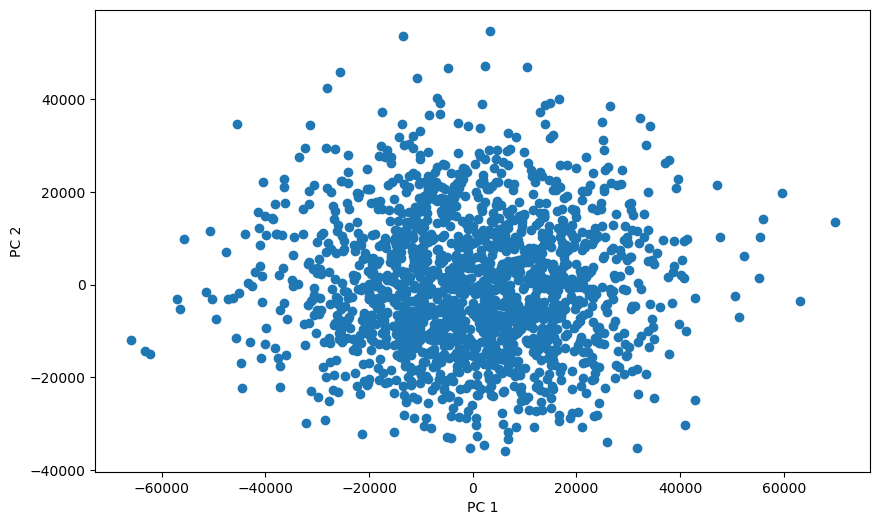

In [101]:
pc_1 = components[:,0]
pc_2 = components[:,1]

plt.figure(figsize=(10,6))
plt.scatter(pc_1,pc_2)
plt.xlabel("PC 1")
plt.ylabel("PC 2")

# Exercise 17

In [102]:
# Find indices of argmin and argmax for both PCs
pc1_argmin = np.argmin(pc_1)
pc1_argmax = np.argmax(pc_1)
pc2_argmin = np.argmin(pc_2)
pc2_argmax = np.argmax(pc_2)

/home/aw/.conda/envs/course02502/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


Text(0.5, 1.0, 'PC2 argmax')

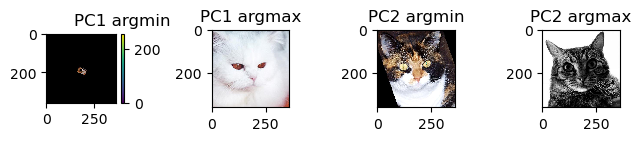

In [103]:
plt.subplot(1,4,1)
io.imshow(create_u_byte_image_from_vector(data_matrix[pc1_argmin,:],360,360,3))
plt.title('PC1 argmin')
plt.subplot(1,4,2)
io.imshow(create_u_byte_image_from_vector(data_matrix[pc1_argmax,:],360,360,3))
plt.title('PC1 argmax')
plt.subplot(1,4,3)
io.imshow(create_u_byte_image_from_vector(data_matrix[pc2_argmin,:],360,360,3))
plt.title('PC2 argmin')
plt.subplot(1,4,4)
io.imshow(create_u_byte_image_from_vector(data_matrix[pc2_argmax,:],360,360,3))
plt.title('PC2 argmax')

# Exercise 18

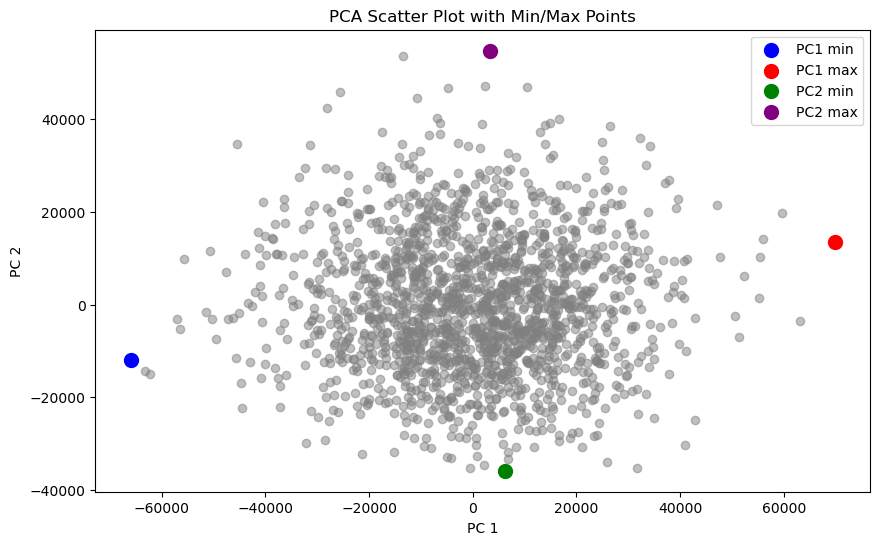

In [104]:
plt.figure(figsize=(10,6))

# Plot main scatter
plt.scatter(pc_1, pc_2, color='gray', alpha=0.5)

# Plot colored points for argmin and argmax
plt.scatter(pc_1[pc1_argmin], pc_2[pc1_argmin], color='blue', s=100, label='PC1 min')
plt.scatter(pc_1[pc1_argmax], pc_2[pc1_argmax], color='red', s=100, label='PC1 max')
plt.scatter(pc_1[pc2_argmin], pc_2[pc2_argmin], color='green', s=100, label='PC2 min')
plt.scatter(pc_1[pc2_argmax], pc_2[pc2_argmax], color='purple', s=100, label='PC2 max')

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.title("PCA Scatter Plot with Min/Max Points")

plt.show()

# Exercise 19

In [105]:
# Weights
w0 = -200000
w1 = 69000
synth_cat = average_cat + w0 * cats_pca.components_[0, :] + w1 * cats_pca.components_[1, :]

# Exercise 20

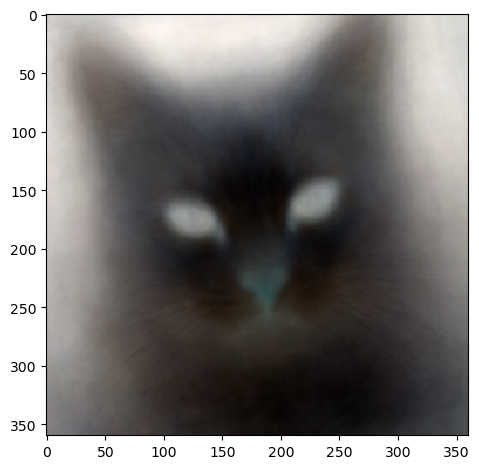

In [106]:
io.imshow(create_u_byte_image_from_vector(synth_cat, 360, 360, 3))

# Exercise 21

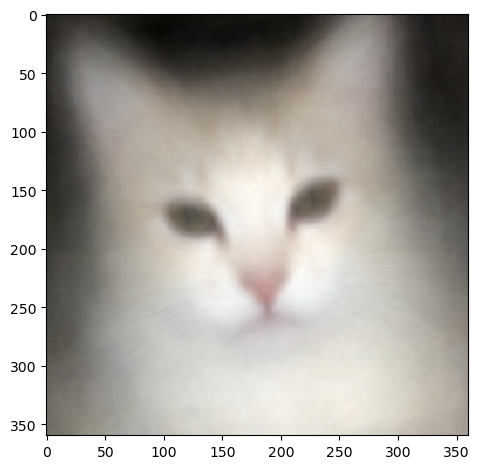

In [107]:
# Weights
w0 = 200000
w1 = -69000
synth_cat = average_cat + w0 * cats_pca.components_[0, :] + w1 * cats_pca.components_[1, :]
io.imshow(create_u_byte_image_from_vector(synth_cat, 360, 360, 3))

# Exercise 22

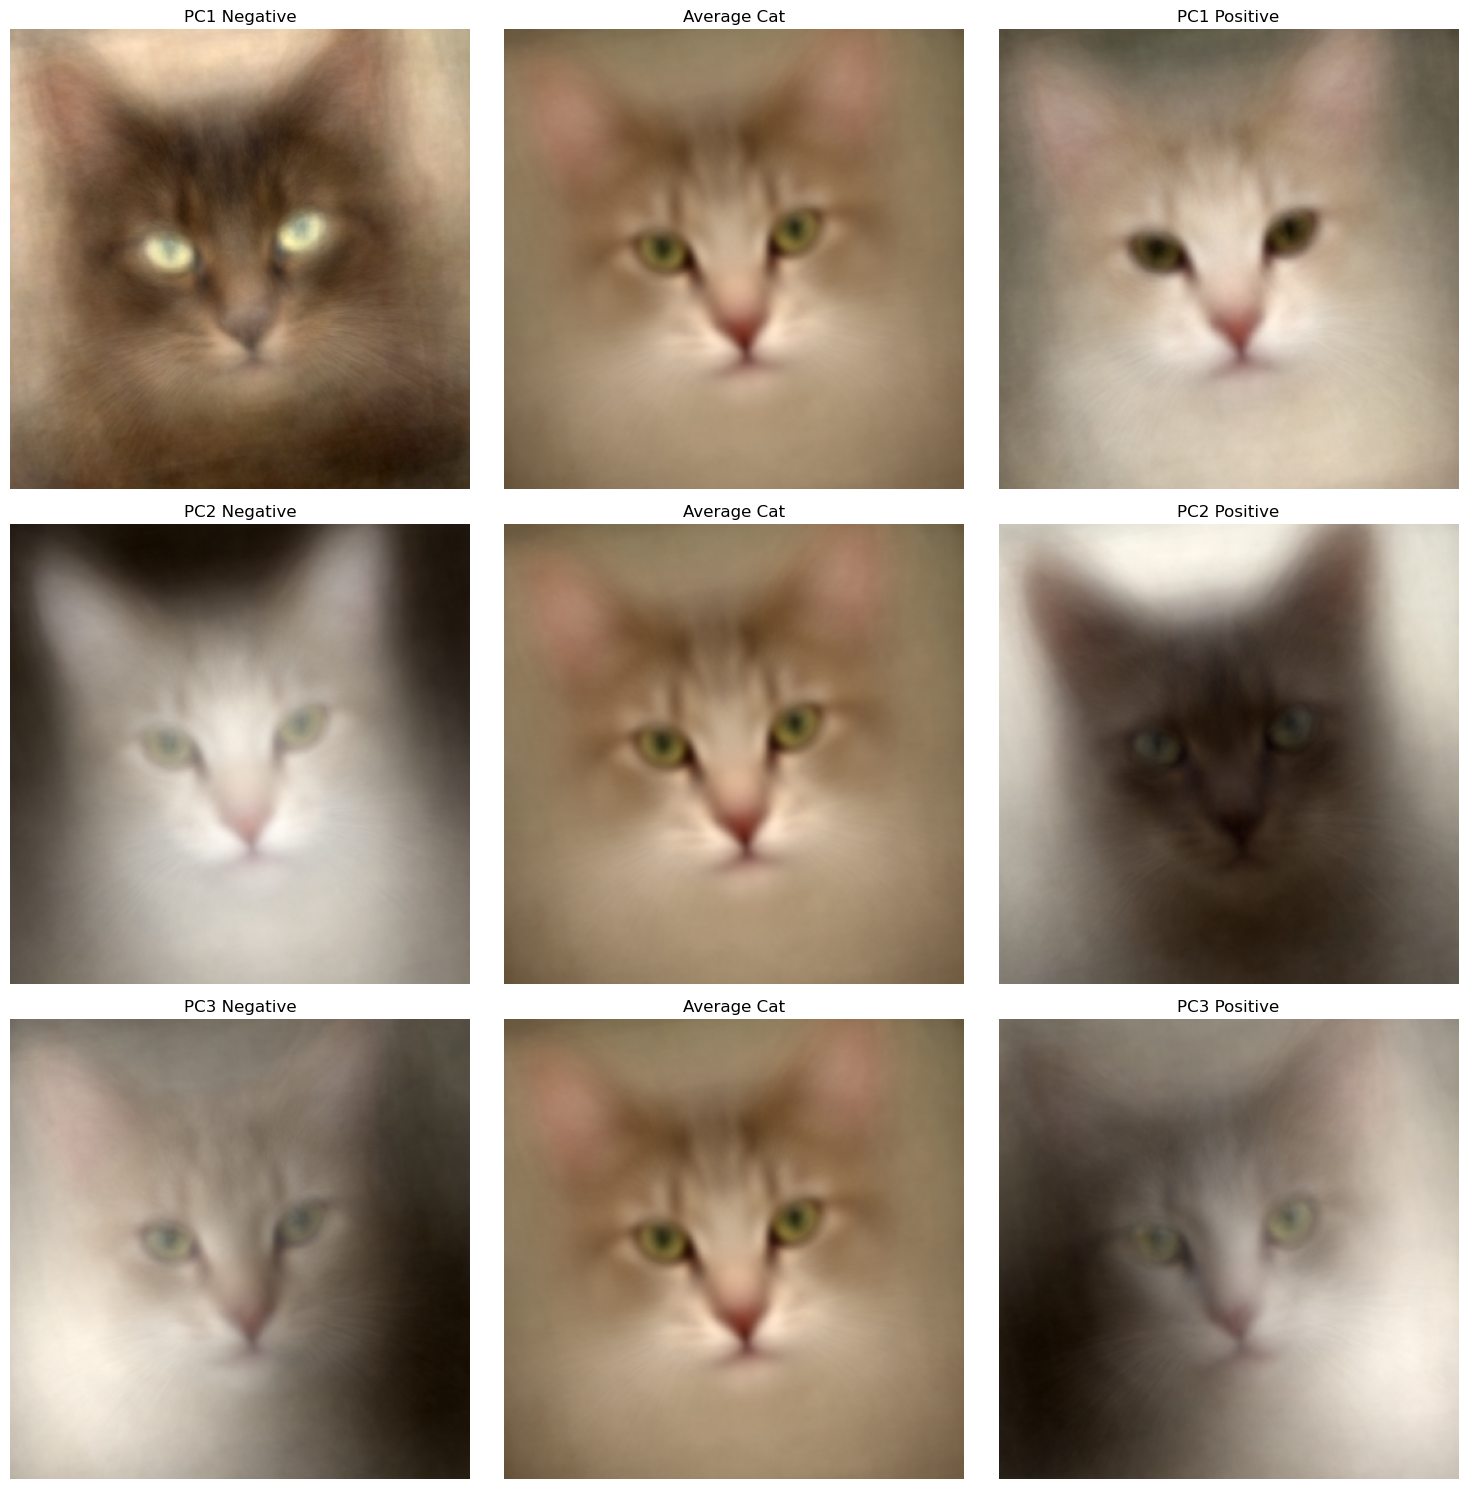

In [108]:
def synthesize_cat(component, factor):
    return average_cat + factor * np.sqrt(cats_pca.explained_variance_[component]) * cats_pca.components_[component, :]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    # Negative variation
    cat_minus = synthesize_cat(i, -3)
    axes[i, 0].imshow(create_u_byte_image_from_vector(cat_minus, 360, 360, 3))
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'PC{i+1} Negative')
    
    # Average cat
    axes[i, 1].imshow(create_u_byte_image_from_vector(average_cat, 360, 360, 3))
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Average Cat')
    
    # Positive variation
    cat_plus = synthesize_cat(i, 3)
    axes[i, 2].imshow(create_u_byte_image_from_vector(cat_plus, 360, 360, 3))
    axes[i, 2].axis('off')
    axes[i, 2].set_title(f'PC{i+1} Positive')

plt.tight_layout()
plt.show()

# Exercise 23

In [109]:
def cat_synthesizer(cats_pca, average_cat, n_components_to_use):
    """
    Synthesizer function for cats
    :param cats_pca: PCA object for cats
    :param average_cat: Average cat image
    :param n_components_to_use: Number of components to use
    """
    synth_cat = average_cat
    for idx in range(n_components_to_use):
        w = random.uniform(-1, 1) * 3 * np.sqrt(cats_pca.explained_variance_[idx])
        synth_cat = synth_cat + w * cats_pca.components_[idx, :]
        cat = create_u_byte_image_from_vector(synth_cat, 360, 360, 3)
        io.imshow(cat)

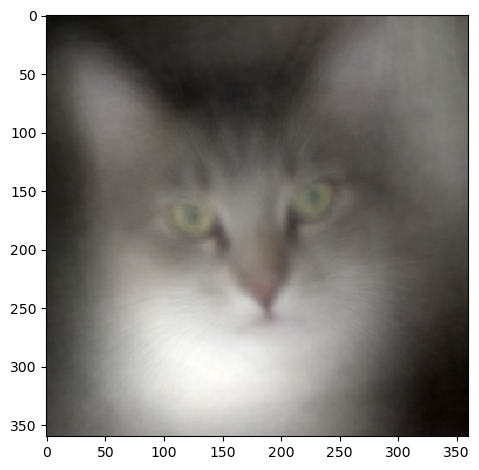

In [110]:
cat_synthesizer(cats_pca, average_cat, 10)

# Exercise 24

In [111]:
im_miss = io.imread("data/MissingCatProcessed.jpg")
im_miss_flat = im_miss.flatten()
im_miss_flat = im_miss_flat.reshape(1, -1)
pca_coords = cats_pca.transform(im_miss_flat)
pca_coords = pca_coords.flatten()
pca_coords.shape

(50,)

# Exercise 25

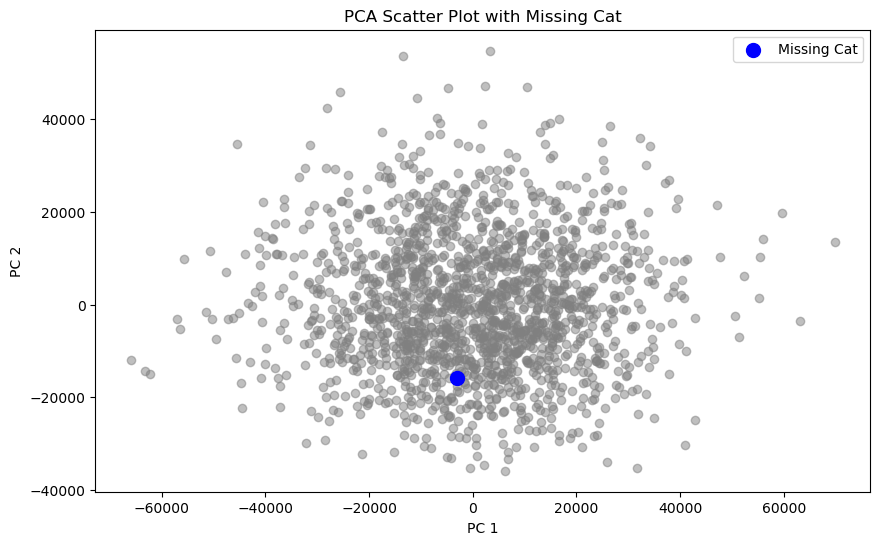

In [112]:
plt.figure(figsize=(10,6))

# Plot main scatter
plt.scatter(pc_1, pc_2, color='gray', alpha=0.5)

# Plot colored points for argmin and argmax
plt.scatter(pca_coords[0], pca_coords[1], color='blue', s=100, label='Missing Cat')

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.title("PCA Scatter Plot with Missing Cat")

plt.show()

It has close neighbors

# Exercise 26

In [113]:
def find_cat(n_components_to_use):
    synth_cat = average_cat
    for idx in range(n_components_to_use):
        synth_cat = synth_cat + pca_coords[idx] * cats_pca.components_[idx, :]
    cat = create_u_byte_image_from_vector(synth_cat, 360, 360, 3)
    io.imshow(cat)

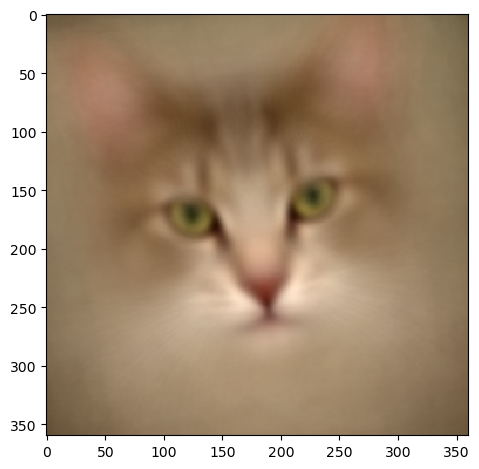

In [114]:
find_cat(1)

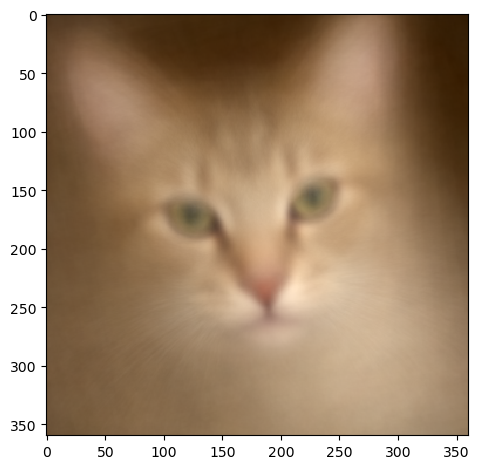

In [115]:
find_cat(10)

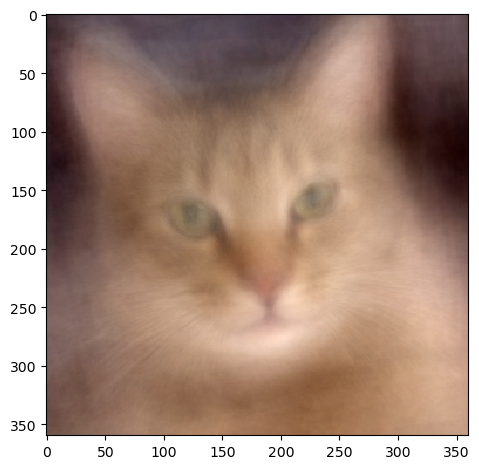

In [116]:
find_cat(50)

# Exercise 27

In [117]:
comp_sub = components - pca_coords
pca_distances = np.linalg.norm(comp_sub, axis=1)

In [118]:
idx_close = np.argmin(pca_distances)
idx_far = np.argmax(pca_distances)

print("Closest cat", idx_close)
print("Furthest cat", idx_far)

Closest cat 314
Furthest cat 85


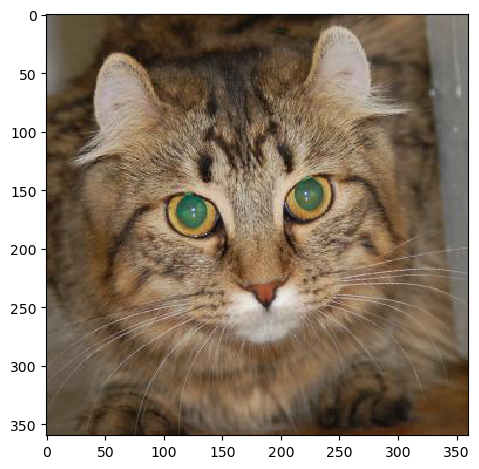

In [119]:
close = create_u_byte_image_from_vector(data_matrix[idx_close, :], 360, 360, 3)
io.imshow(close)

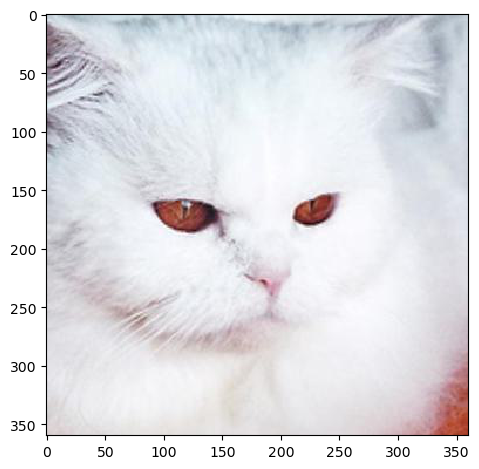

In [120]:
furthest = create_u_byte_image_from_vector(data_matrix[idx_far, :], 360, 360, 3)
io.imshow(furthest)

# Exercise 28

In [121]:
closest_cats = np.argpartition(pca_distances, 1, axis=0)
print(f"5 closest cats: {closest_cats[0:5]}")

5 closest cats: [314 176   2   3   4]


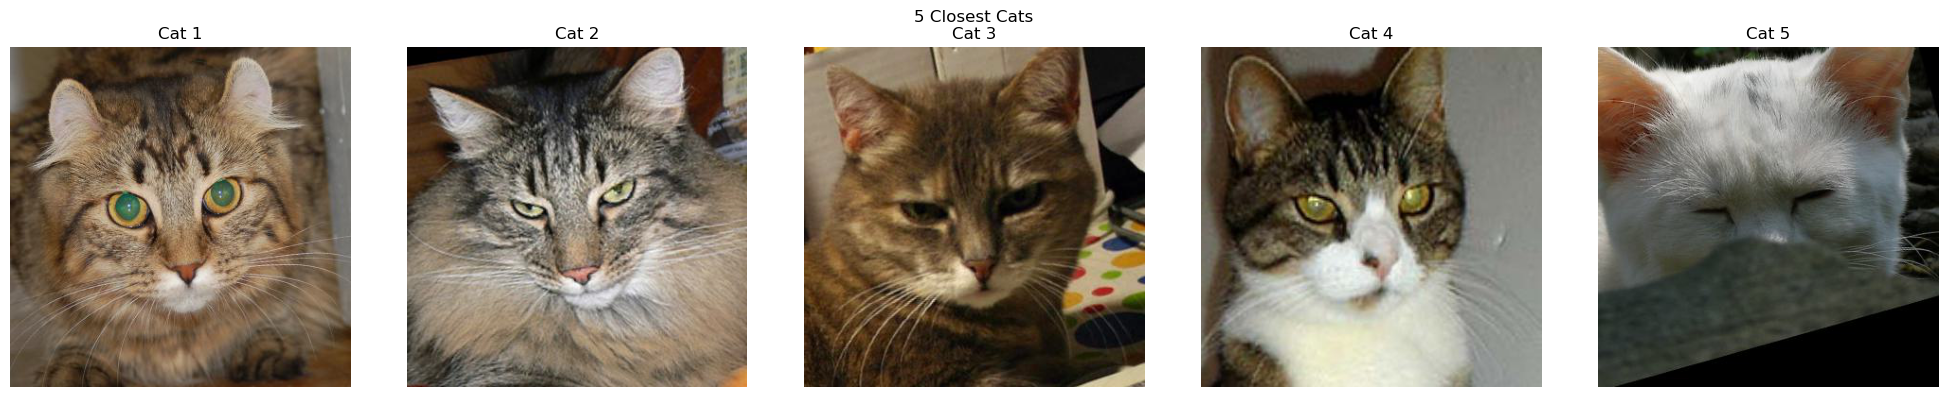

In [122]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('5 Closest Cats')

for i, idx in enumerate(closest_cats[0:5]):
    img = create_u_byte_image_from_vector(data_matrix[idx, :], 360, 360, 3)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Cat {i+1}')

plt.tight_layout()
plt.show()